# Import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
from plotly.offline import init_notebook_mode,plot,iplot
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
from datetime import date
import re 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [3]:
# Фиксируем RANDOM_SEED и версию пакетов, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42
CURRENT_DATE = '03/12/2020'

!pip freeze > requirements.txt

# Loading data

In [4]:
df_train = pd.read_csv('/kaggle/input/sf-dst-restaurant-rating/main_task.csv')
df_test = pd.read_csv('/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv')

df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['Rating'] = 0 
data = df_test.append(df_train, sort=False).reset_index(drop=True) 
display(df_train.head())
display(df_test.head())

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0


In [5]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


Подробнее по признакам:

* City: Город
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com'
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

## Начнем манипуляции с данными


In [6]:
# Вынесем информацию о наличии пропуска как отдельный признак и заполним пропуски медианным значением
data['Number of Reviews Was NAN'] = data['Number of Reviews'].isna()
data['Number of Reviews'] = data['Number of Reviews'].fillna(
    data['Number of Reviews'].mean())

In [7]:
# Так же вынесем информацию о пропусках и заменим пропущенные значения
data['Cuisine Style Was NAN'] = data['Cuisine Style'].isna()
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Unknown']")
# Обработаем значения и посчитаем количество кухонь представленных в ресторане
data['Number of Styles'] = data['Cuisine Style'].str[2:-2].str.split("', '")
data['Number of Styles'] = data['Number of Styles'].apply(lambda x: 0 if x is np.nan else len(x))

### Посмотрим, какую информцию можно получить из городов

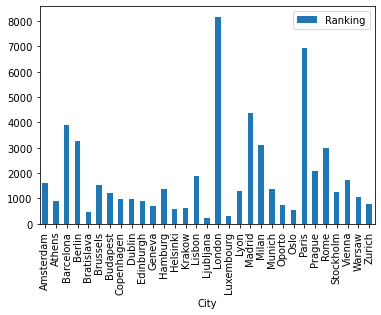

In [8]:
# Рассмотрим распределение ранга ресторанов по городам:
data.pivot_table(values = ['Ranking'], 
               index = 'City', 
               aggfunc = 'mean').plot(kind = 'bar')

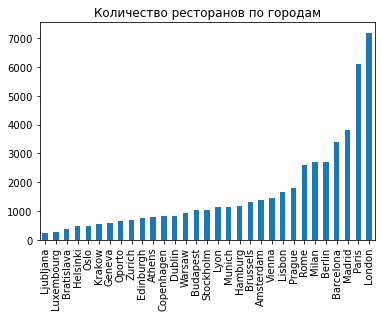

In [9]:
#Так же количество ресторанов по городам:
data['City'].value_counts(ascending=True).plot(kind='bar', title='Количество ресторанов по городам')

In [10]:
# Логично будет создать новый признак - количество ресторанов в одном городе
rest_count = data.groupby('City')['Restaurant_id'].count().to_dict()
data['Restaurants in City'] = data['City'].map(rest_count)

In [11]:
# На основе нового признака можно получить условный рейнтиг города по ресторанам
data['City ranking'] = data['Ranking'] / data['Restaurants in City']

In [12]:
# Создадим новый признак на основе того, является ли город столицей
city_list = [
    'London',
    'Paris', 
    'Madrid', 
    'Berlin', 
    'Rome', 
    'Prague', 
    'Lisbon', 
    'Vienna', 
    'Amsterdam', 
    'Stockholm', 
    'Budapest', 
    'Warsaw', 
    'Dublin', 
    'Copenhagen', 
    'Athens', 
    'Oslo', 
    'Luxembourg', 
    'Helsinki', 
    'Bratislava', 
    'Ljubljana', 
    'Brussels'
]
data['Capital'] = data['City'].apply(lambda x: 1 if x in city_list else 0)

In [13]:
# На основании города так же можем извлечь и страну
# Присвоим каждому городу код страны
countries = {
    'London': 'GB',
    'Paris': 'FR',
    'Madrid': 'ES',
    'Barcelona': 'ES',
    'Berlin': 'DE',
    'Milan': 'IT',
    'Rome': 'IT',
    'Prague': 'CZ',
    'Lisbon': 'PT',
    'Vienna': 'AT',
    'Amsterdam': 'NL',
    'Brussels': 'BE',
    'Hamburg': 'DE',
    'Munich': 'DE',
    'Lyon': 'FR',
    'Stockholm': 'SE',
    'Budapest': 'HU',
    'Warsaw': 'PL',
    'Dublin': 'IE',
    'Copenhagen': 'DK',
    'Athens': 'GR',
    'Edinburgh': 'GB',
    'Zurich': 'CH',
    'Oporto': 'PT',
    'Geneva': 'CH',
    'Krakow': 'PL',
    'Oslo': 'NO',
    'Helsinki': 'FI',
    'Bratislava': 'SK',
    'Luxembourg': 'LU',
    'Ljubljana': 'SI',
}

data['Country'] = data['City'].map(countries)
# и закодируем
countries_le = LabelEncoder()
countries_le.fit(data['Country'])
data['Country Code'] = countries_le.transform(data['Country'])

In [14]:
cities_le = LabelEncoder()
cities_le.fit(data['City'])
data['City Code'] = cities_le.transform(data['City'])

In [15]:
# Добавим новые признаки извне, например, население городов
populations = {
    'London': 8567000, 
    'Paris':  9904000, 
    'Madrid':  5567000,
    'Barcelona':  4920000,
    'Berlin':  3406000,
    'Milan':  2945000,
    'Rome':  3339000,
    'Prague':  1162000,
    'Lisbon':  2812000,
    'Vienna':  2400000,
    'Amsterdam':  1031000,
    'Brussels':  1743000,
    'Hamburg':  1757000,
    'Munich':  1275000,
    'Lyon':  1423000,
    'Stockholm':  1264000,
    'Budapest':  1679000,
    'Warsaw':  1707000,
    'Dublin':  1059000,
    'Copenhagen':  1085000,
    'Athens':  3242000,
    'Edinburgh':  504966,
    'Zurich':  1108000,
    'Oporto':  1337000,
    'Geneva':  1240000,
    'Krakow':  756000,
    'Oslo':  835000,
    'Helsinki':  1115000,
    'Bratislava':  423737,
    'Luxembourg':  107260,
    'Ljubljana':  314807,
}


data['Population'] = data['City'].map(populations)

In [16]:
# Так же можем добавить и количество ВВП на душу
economies = {
    'GB' : 46870,
    'FR' : 45893,
    'ES' : 41998, 
    'DE' : 53449, 
    'IT' : 40923,
    'CZ' : 39511,  
    'PT' : 33211,
    'AT' : 52813,
    'HU' : 33033,
    'NL' : 58095, 
    'BE' : 49912,
    'SE' : 54666,  
    'PL' : 33072,
    'IE' : 83001,
    'DK' : 52279, 
    'GR' : 30501,  
    'CH' : 65077, 
    'NO' : 76243, 
    'FI' : 48098, 
    'SK' : 36878, 
    'LU' : 113550, 
    'SI' : 38343
}

data['Economy'] = data['Country'].map(economies)
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Cuisine Style Was NAN,Number of Styles,Restaurants in City,City ranking,Capital,Country,Country Code,City Code,Population,Economy
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,False,2,6108,2.122299,1,FR,8,24,9904000,45893
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,False,5,475,0.223158,1,FI,7,12,1115000,48098
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,False,1,745,1.087248,0,GB,9,9,504966,46870
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,False,5,7193,0.232031,1,GB,9,16,8567000,46870
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,False,6,380,0.097368,1,SK,21,4,423737,36878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,False,4,2694,0.185598,0,IT,13,20,2945000,40923
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,False,5,6108,1.038147,1,FR,8,24,9904000,45893
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,False,2,1033,1.599226,1,SE,19,27,1264000,54666
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,False,5,925,0.692973,1,PL,17,29,1707000,33072


## Price

In [17]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [18]:
# Как видно выше большинство ресторанов имеют значение цены "$$ -$$$", 
# заменим символы на цифры и пропущенные значения на 2
data['Price Range'] = data['Price Range'].map({'$':1,'$$ - $$$':2,'$$$$':3}).fillna(2)

## Number of Reviews


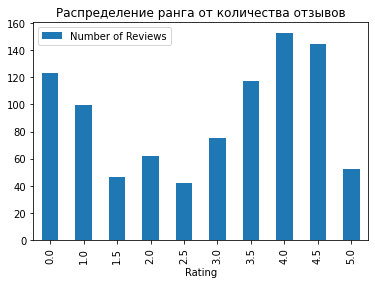

In [19]:
#Посмотрим распределение ранга от количества отзывов:
data.pivot_table(values = ['Number of Reviews'], 
               index = 'Rating', 
               aggfunc = 'mean').plot(kind = 'bar', title='Распределение ранга от количества отзывов');

In [20]:
# Создадим признак - количество отзывов о ресторанах в городе:
rev_count = data.groupby('City')['Number of Reviews'].sum().sort_values().to_dict()
data['Rev in City'] = data['City'].map(rev_count)

In [21]:
# Создадим новый отзыв на основании соотношения количества отзывов к рейтингу
data['Rev +-'] = data['Number of Reviews']/data['Ranking']
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Restaurants in City,City ranking,Capital,Country,Country Code,City Code,Population,Economy,Rev in City,Rev +-
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,6108,2.122299,1,FR,8,24,9904000,45893,717048.118205,0.000309
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,475,0.223158,1,FI,7,12,1115000,48098,32996.193504,0.915094
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,745,1.087248,0,GB,9,9,504966,46870,174716.895128,0.034568
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,7193,0.232031,1,GB,9,16,8567000,46870,986670.258547,0.121031
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,380,0.097368,1,SK,21,4,423737,36878,23766.858205,4.378378


## Reviews

In [22]:
# очистим данные
data['Review Date'] = data['Reviews'].str[2:-2].str.split("\], \[").str[1].replace('\'', '', regex=True)
# Создадим призна, указывающий был ли написан отзыв
data['Is Reviewed'] = data['Review Date'].apply(lambda x: 0 if x == '' else 1)

In [23]:
# Заполняем пропущенные значения и деаем списки из дат
data['Review Date'] = data['Review Date'].replace('', np.nan)
data['Review Date'] = data['Review Date'].str.split(", ")

In [24]:
# Создаем два новых атрибута - количество дней между отзывами 
# и количество дней с момента последнего отзыва
def datediff (dateslist):
    return abs(max( [dt.strptime(d, '%m/%d/%Y') for d in dateslist]) 
               - min( [dt.strptime(d, '%m/%d/%Y') for d in dateslist])).days

def dayspassed (dateslist):
    return abs(max( [dt.strptime(d, '%m/%d/%Y') for d in dateslist])
              - dt.strptime(CURRENT_DATE, '%m/%d/%Y')).days
    
data['Days Between'] = data['Review Date'][~data['Review Date'].isna()].apply(lambda d: datediff(d))
data['Days Since'] = data['Review Date'][~data['Review Date'].isna()].apply(lambda d: dayspassed(d))

In [25]:
# заполняем пустые значния 0, так как можно считать, 
# что если отзыва нет, то человек просто поставил оценку ресторану
data['Days Between'] = data['Days Between'].fillna(0)
data['Days Since'] = data['Days Since'].fillna(0)

In [26]:
# очистим этот признак
data['Numeric ID'] = data['ID_TA'].apply(lambda id_ta: int(id_ta[1:]))

## Создание dummy-переменных


In [27]:
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
#styles = data['Cuisine Style'].str[2:-2].str.split("', '").apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')
#data = data.join(styles)

## Исключаем object столбцы из датафрейма

In [28]:
data =  data.drop(['Cuisine Style', 'Restaurant_id','Country','Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA', 'Review Date', 'Cuisine Style Was NAN'], axis=1)

## Рассмотрим корреляцию признаков

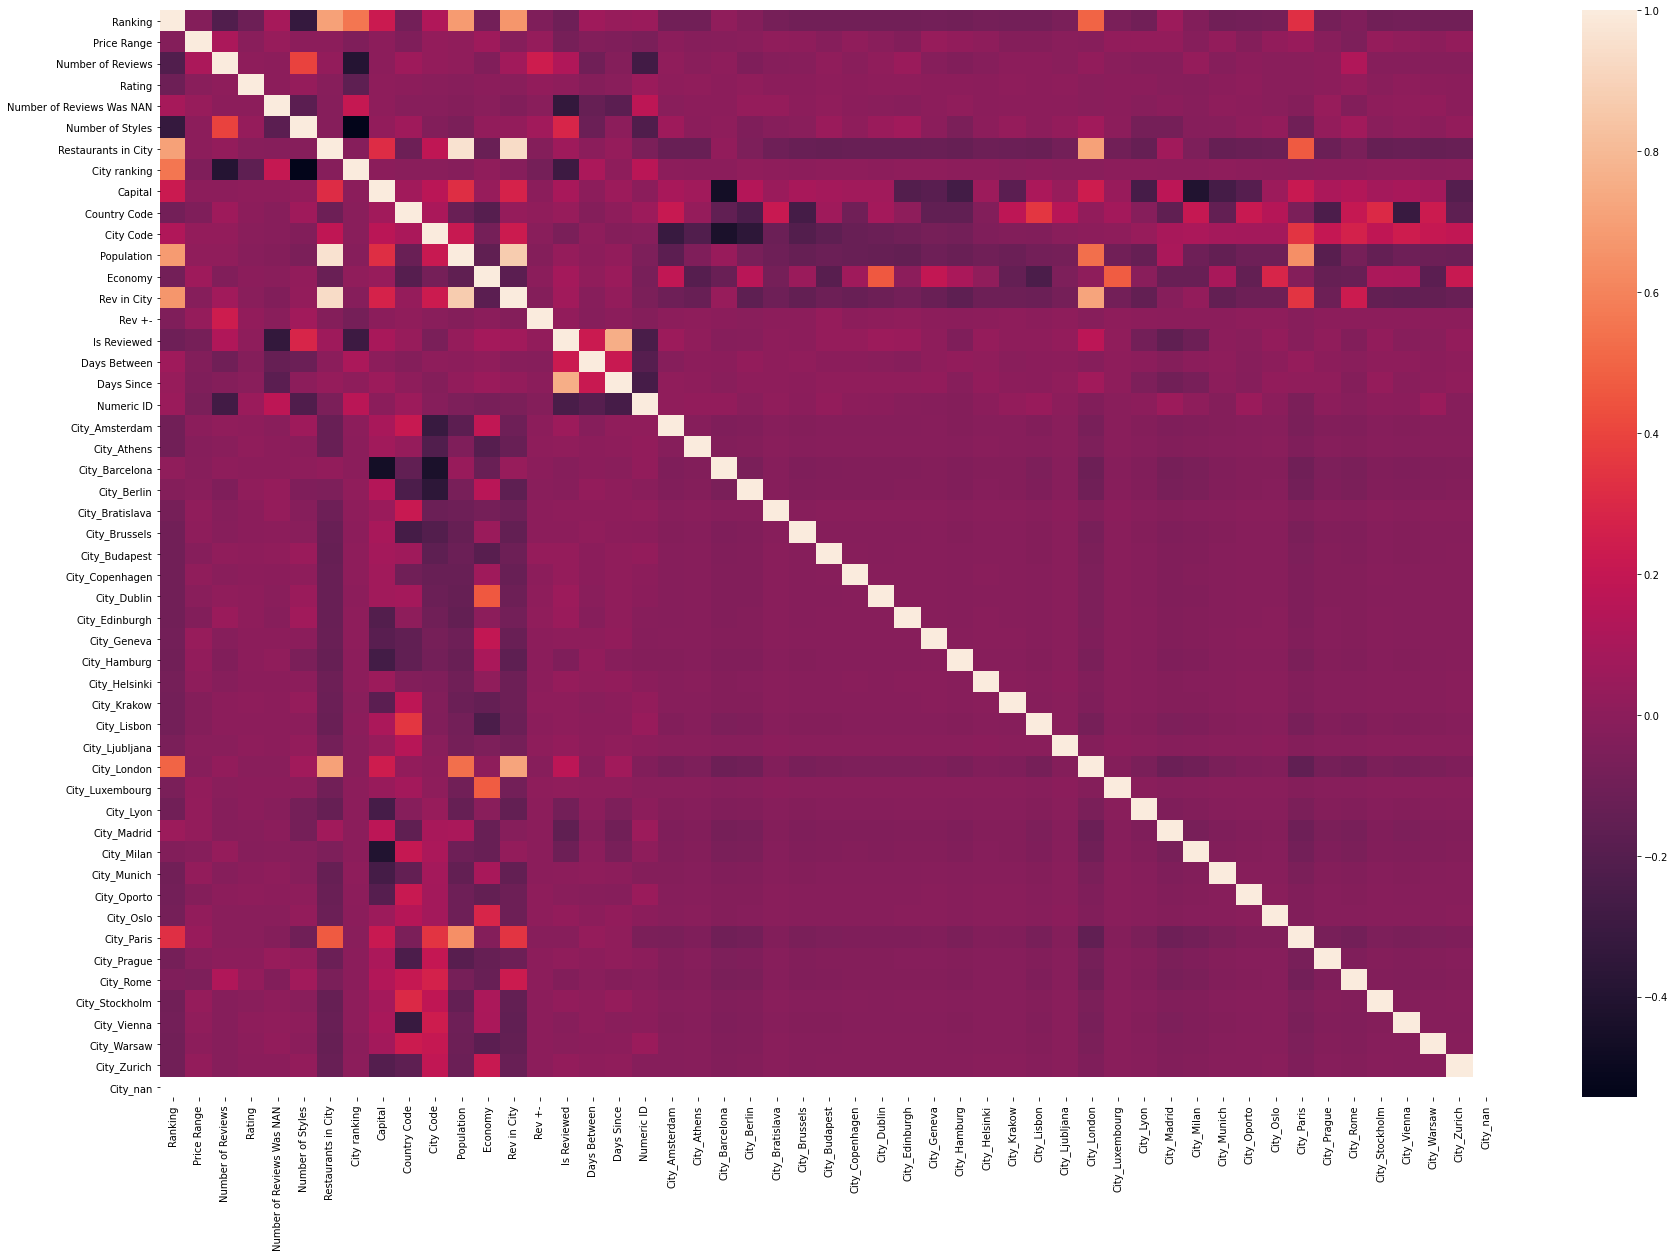

In [29]:
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [30]:
data.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Number of Reviews Was NAN,Number of Styles,Restaurants in City,City ranking,Capital,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
11038,922.0,2.0,136.000000,1,4.5,False,5,7193,0.128180,1,...,0,0,0,0,0,0,0,0,0,0
25471,12709.0,2.0,124.471197,1,4.0,True,1,7193,1.766857,1,...,0,0,0,0,0,0,0,0,0,0
41565,251.0,1.0,65.000000,1,5.0,False,5,836,0.300239,1,...,0,0,0,0,0,0,0,0,0,0
40094,10.0,2.0,299.000000,1,4.5,False,8,1145,0.008734,0,...,0,0,0,0,0,0,0,0,0,0
29892,7465.0,2.0,369.000000,1,2.5,False,4,3395,2.198822,0,...,0,0,0,0,0,0,0,0,0,0
19878,1680.0,2.0,14.000000,1,4.0,False,2,1021,1.645446,1,...,0,0,0,0,0,0,0,0,0,0
25960,910.0,1.0,24.000000,1,4.5,False,4,745,1.221477,0,...,0,0,0,0,0,0,0,0,0,0
4151,2010.0,2.0,3.000000,0,0.0,False,1,925,2.172973,1,...,0,0,0,0,0,0,0,1,0,0
13525,1145.0,2.0,126.000000,1,3.5,False,5,1647,0.695203,1,...,0,0,0,0,0,0,0,0,0,0
38730,1903.0,2.0,134.000000,1,4.0,False,5,6108,0.311559,1,...,0,0,1,0,0,0,0,0,0,0


# Data Preprocessing

In [31]:
# Let's separate test data
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # target
X = train_data.drop(['Rating'], axis=1)

In [32]:
# To test the model before sending the prediction isolating 25%

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Model

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [34]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [35]:
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [36]:
# Рейтинг указан с шагом 0.5 - округлим предсказываемое значение

def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])

y_pred = predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [37]:
# Теперь посмотрим насколько хороша модель
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1669


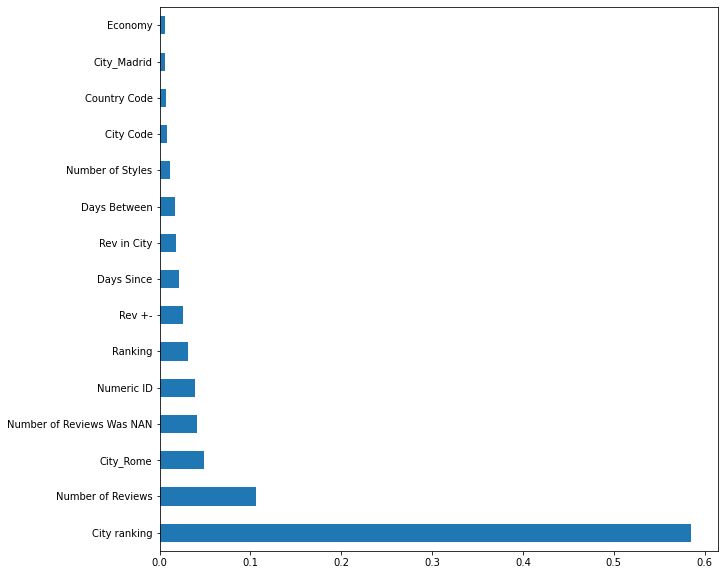

In [38]:
# Какие параметры работают лучше всего
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Submission

In [39]:
test_data = test_data.drop(['Rating'], axis=1)

In [40]:
predict_submission = predict(test_data)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [41]:
sample_submission = pd.read_csv('/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv')
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
